In [6]:
import matplotlib
import numpy as np
import os
import sys
import time
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.lenses.test import SampleStrongLens
from mejiro.exposure import Exposure
from mejiro.lenses import lens_util

In [7]:
sample_lens = SampleStrongLens()
roman = Roman()
band = 'F106'
zp = roman.zp_dict['SCA01'][band]
exposure_time = 146

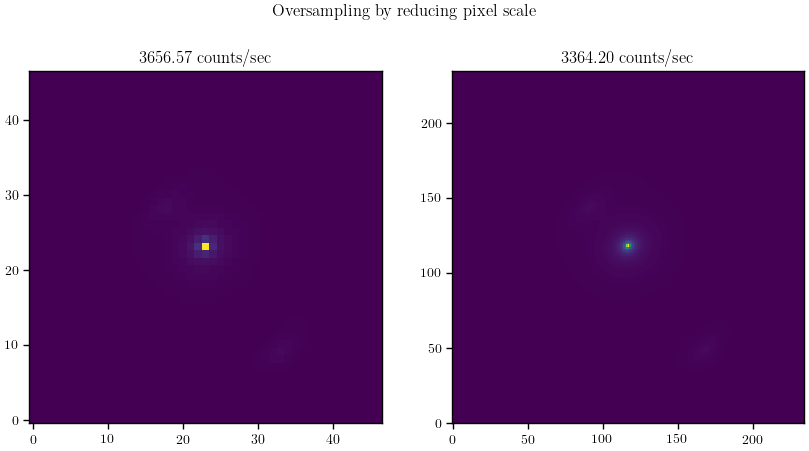

In [8]:
lens_1 = deepcopy(sample_lens)
model_1 = lens_1.get_array(47 * 1, 5.17, band, zp, kwargs_numerics={'supersampling_factor': 1})

lens_2 = deepcopy(sample_lens)
model_2 = lens_2.get_array(47 * 5, 5.17, band, zp, kwargs_numerics={'supersampling_factor': 1})

_, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(model_1)
ax[1].imshow(model_2)

ax[0].set_title(f'{np.sum(model_1):.2f} counts/sec')
ax[1].set_title(f'{np.sum(model_2):.2f} counts/sec')

plt.suptitle('Oversampling by reducing pixel scale')
plt.show()

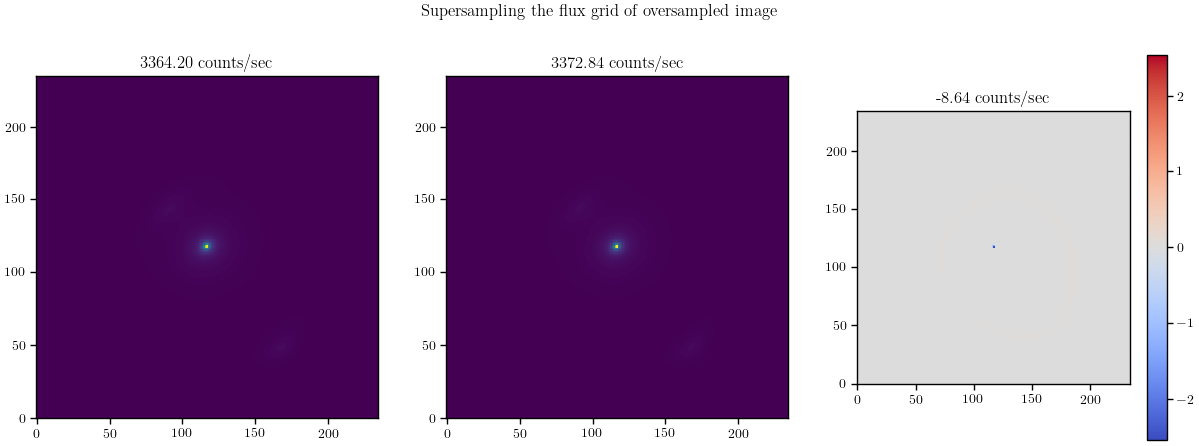

In [9]:
lens_1 = deepcopy(sample_lens)
model_1 = lens_1.get_array(47 * 5, 5.17, band, zp, kwargs_numerics={'supersampling_factor': 1})

lens_2 = deepcopy(sample_lens)
model_2 = lens_2.get_array(47 * 5, 5.17, band, zp, kwargs_numerics={'supersampling_factor': 5})

_, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(model_1)
ax[1].imshow(model_2)
ax2 = ax[2].imshow(model_1 - model_2, cmap='coolwarm', vmin=-plot_util.get_v(model_1 - model_2),
                   vmax=plot_util.get_v(model_1 - model_2))

ax[0].set_title(f'{np.sum(model_1):.2f} counts/sec')
ax[1].set_title(f'{np.sum(model_2):.2f} counts/sec')
ax[2].set_title(f'{np.sum(model_1 - model_2):.2f} counts/sec')

plt.colorbar(ax2)
plt.suptitle('Supersampling the flux grid of oversampled image')
plt.show()

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


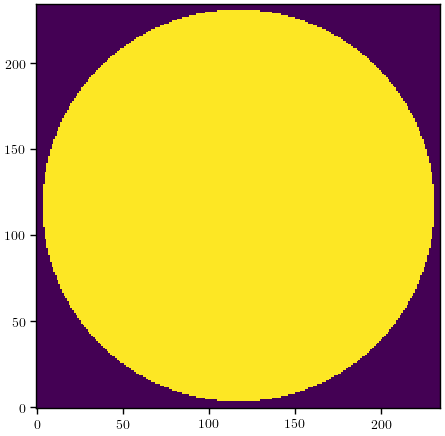

In [12]:
supersampling_factors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
flux_regular, flux_adaptive = [], []
calc_time_regular, calc_time_adaptive = [], []
chi2_regular, chi2_adaptive = [], []

compare_lens = deepcopy(sample_lens)
compare_model = compare_lens.get_array(47 * 5, 5.17, band, zp,
                                       kwargs_numerics={'supersampling_factor': 19, 'compute_mode': 'regular'})

for factor in tqdm(supersampling_factors):
    lens = deepcopy(sample_lens)
    start = time.time()
    model = lens.get_array(47 * 5, 5.17, band, zp,
                           kwargs_numerics={'supersampling_factor': factor, 'compute_mode': 'regular'})
    end = time.time()
    flux_regular.append(np.sum(model))
    calc_time_regular.append(end - start)
    chi2_regular.append(stats.chi_square(compare_model, model))

region = util.create_centered_circle(47 * 5, 2.5 / (0.11 / 5))
plt.imshow(region)

for factor in tqdm(supersampling_factors):
    lens = deepcopy(sample_lens)
    start = time.time()
    model = lens.get_array(47 * 5, 5.17, band, zp,
                           kwargs_numerics={'supersampling_factor': factor, 'compute_mode': 'adaptive',
                                            'supersampled_indexes': region})
    end = time.time()
    flux_adaptive.append(np.sum(model))
    calc_time_adaptive.append(end - start)
    chi2_adaptive.append(stats.chi_square(compare_model, model))

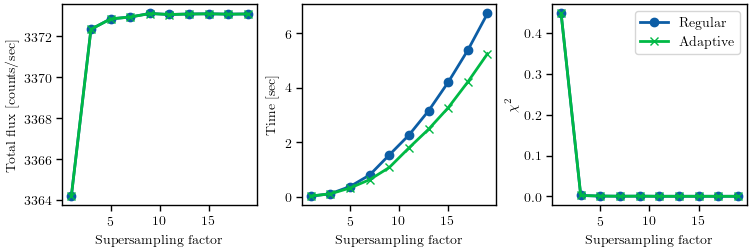

In [13]:
_, ax = plt.subplots(1, 3, figsize=(7.5, 2.5), constrained_layout=True)

ax[0].plot(supersampling_factors, flux_regular, 'o-', label='Regular')
ax[0].plot(supersampling_factors, flux_adaptive, 'x-', label='Adaptive')
ax[0].set_xlabel('Supersampling factor')
ax[0].set_ylabel('Total flux [counts/sec]')

ax[1].plot(supersampling_factors, calc_time_regular, 'o-', label='Regular')
ax[1].plot(supersampling_factors, calc_time_adaptive, 'x-', label='Adaptive')
ax[1].set_xlabel('Supersampling factor')
ax[1].set_ylabel('Time [sec]')

ax[2].plot(supersampling_factors, chi2_regular, 'o-', label='Regular')
ax[2].plot(supersampling_factors, chi2_adaptive, 'x-', label='Adaptive')
ax[2].set_xlabel('Supersampling factor')
ax[2].set_ylabel(r'$\chi^2$')
ax[2].legend()

plt.show()